# 합성곱 신경망(CNN : Convolutional Nerual Network) (Part 3/3)
**오늘은 CIFAR-10 데이터를 이용해서 CNN 신경망에 대해서 코드실습해 보려고 한다.**

## CIFAR-10 Dataset
+ https://www.cs.toronto.edu/~kriz/cifar.html
+ The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset.
+ They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary as summary_

USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

## 데이터 Import & 전처리

In [2]:
from torchvision import transforms, datasets
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10("../data/CIFAR_10/",
                     train = True,
                     download = True,
                     transform = transforms.Compose([
                         transforms.RandomHorizontalFlip(), # 랜덤으로 이미지의 상하반전함
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5),
                                              (0.5, 0.5, 0.5))])), batch_size = 64, shuffle = True) # 픽셀의 값을 노말라이즈함(평균, 표준편차,)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10("../data/CIFAR_10",
                     train = False,
                     transform = transforms.Compose([
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5),
                                              (0.5, 0.5, 0.5))])), batch_size = 64)

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

C:\anaconda3\envs\JSY_GPU\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] 지정된 모듈을 찾을 수 없습니다
  warn(f"Failed to load image Python extension: {e}")


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10/


### 데이터 살펴보기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label : horse
img's shape : torch.Size([3, 32, 32])


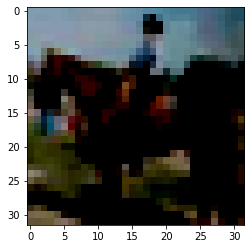

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



label : deer
img's shape : torch.Size([3, 32, 32])


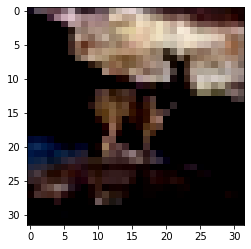

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



label : horse
img's shape : torch.Size([3, 32, 32])


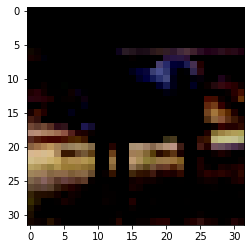

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



label : airplane
img's shape : torch.Size([3, 32, 32])


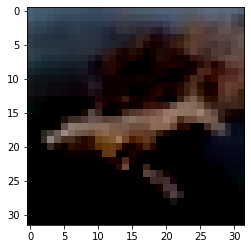

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



label : frog
img's shape : torch.Size([3, 32, 32])


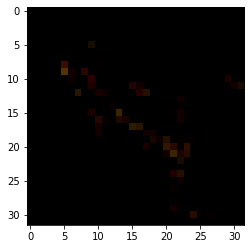

In [7]:
_, (imgs, labels) = list(enumerate(train_loader))[27]

i = 0
for img, label in zip(imgs, labels):
    if i != 5:
        print("label :", label_names[label])
        print("img's shape : {}".format(img.shape))
        plt.imshow(np.transpose(img, (1,2,0)))
        plt.show()
        print()
        i+=1

## 학습, 검증 함수 정의

In [8]:
loss_fn = nn.CrossEntropyLoss()

def calc_acc(X, Y):
    x_val, x_idx = torch.max(X, dim=1)
    return (x_idx == Y).sum().item()

def train(EPOCHS, model, train_loader, test_loader, opt):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    for epoch in range(1, EPOCHS+1):
        model.train()
        train_acc = 0
        print("<<< EPOCH {} >>>".format(epoch))
        for batch_idx, (img,label) in enumerate(notebook.tqdm(train_loader)):
            img, label = img.to(DEVICE), label.to(DEVICE)
            
            output = model(img)                 # 순전파
            loss = loss_fn(output, label)       # 오차 계산
            
            opt.zero_grad()                     # opt내부 값 초기화
            loss.backward()                     # 오차 역전파
            opt.step()                          # 가중치 갱신
            
            train_acc += calc_acc(output, label)
            if batch_idx % 100 == 0 and batch_idx != 0:
                print("Training : [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Acc : {:.3f}".format(
                    batch_idx * len(img), 
                    len(train_loader.dataset), 
                    100. * batch_idx / len(train_loader), 
                    loss.item(),
                    train_acc / len(train_loader.dataset)))
                
        print("Training : [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Acc : {:.3f}".format(
                    len(train_loader.dataset), 
                    len(train_loader.dataset), 
                    100. * batch_idx / len(train_loader), 
                    loss.item(),
                    train_acc / len(train_loader.dataset)))
        t_loss, t_acc = evaluate(model, test_loader)
        print("[{}] Test Loss : {:.4f}\t accuracy: {:.2f}%\n".format(epoch, t_loss, t_acc*100.))

        train_loss_history.append(loss.item())
        train_acc_history.append(train_acc / len(train_loader.dataset))

        test_loss_history.append(t_loss.item())
        test_acc_history.append(t_acc)

    return train_loss_history, train_acc_history, test_loss_history, test_acc_history
                
def evaluate(model, test_loader):
    model.eval()
    t_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img, label in notebook.tqdm(test_loader):
            img, label = img.to(DEVICE), label.to(DEVICE)
            
            output = model(img)
            t_loss += loss_fn(output, label)
            
            correct += calc_acc(output, label)

    t_loss /= len(test_loader)
    t_acc = correct / len(test_loader.dataset)
    return t_loss, t_acc

## 모델 정의

### Linear

In [9]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()

        self.fc1 = nn.Linear(3*32*32, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 10)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3*32*32)

        x = self.fc1(x)
        x = self.act_fn(x)

        x = self.fc2(x)
        x = self.act_fn(x)

        x = self.fc3(x)
        return x

### CNN

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.bn = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 10)

        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.AdaptiveAvgPool2d(1)
        self.act_fn = nn.ReLU()

        self.drop = nn.Dropout(p = 0.25)
        
    def forward(self, x):
        x = self.conv1(x)           # (batch, 3, 32, 32) -> (batch, 16, 32, 32)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 16, 32, 32) -> (batch, 16, 16, 16)

        x = self.conv2(x)           # (batch, 16, 16, 16) -> (batch, 32, 16 ,16)
        x = self.bn(x)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 32, 16, 16) -> (batch, 32, 8, 8)
        
        x = self.conv3(x)           # (batch, 32, 8, 8) -> (batch, 64, 8, 8)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 64, 8, 8) -> (batch, 64, 4, 4)

        x = self.conv4(x)           # (batch, 64, 4, 4) -> (batch, 128, 4, 4)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 128, 4, 4) -> (batch, 128, 2, 2)

        x = self.flatten(x)         # (batch, 128, 2, 2) -> (batch, 128, 1, 1)
        x = x.view(-1, 128*1*1)     # (batch, 128, 1, 1) -> (batch, 128)

        x = self.fc1(x)             # (batch, 128) -> (batch, 32)
        x = self.act_fn(x)
        x = self.drop(x)

        x = self.fc2(x)              # (batch, 32) -> (batch, 10)
        return x

### CNN(+attention)

In [36]:
class CNN_with_Att(nn.Module):
    def __init__(self):
        super(CNN_with_Att, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.att1 = nn.Conv2d(16, 32, 3, 1, 1)
        self.att2 = nn.Conv2d(64, 128, 3, 1, 1)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 10)

        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.AdaptiveAvgPool2d(1)
        self.sigmoid = nn.Sigmoid()
        self.act_fn = nn.LeakyReLU()

        self.drop = nn.Dropout(p = 0.25)
        
    def forward(self, x):
        x = self.conv1(x)           # (batch, 3, 32, 32) -> (batch, 16, 32, 32)
        x = self.bn1(x)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 16, 32, 32) -> (batch, 16, 16, 16)
        
        att = self.att1(x)           # (batch, 16, 16, 16) -> (batch, 32, 16 ,16)
        att = self.sigmoid(att)
        x = self.conv2(x)           # (batch, 16, 16, 16) -> (batch, 32, 16 ,16)
        x = x * att
        x = self.bn2(x)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 32, 16, 16) -> (batch, 32, 8, 8)
        
        x = self.conv3(x)           # (batch, 32, 8, 8) -> (batch, 64, 8, 8)
        x = self.bn3(x)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 64, 8, 8) -> (batch, 64, 4, 4)
        
        att = self.att2(x)          # (batch, 64, 4, 4) -> (batch, 128, 4, 4)
        att = self.sigmoid(att)
        x = self.conv4(x)           # (batch, 64, 4, 4) -> (batch, 128, 4, 4)
        x = x * att
        x = self.bn4(x)
        x = self.act_fn(x)
        x = self.pool(x)            # (batch, 128, 4, 4) -> (batch, 128, 2, 2)

        x = self.flatten(x)         # (batch, 128, 2, 2) -> (batch, 128, 1, 1)
        x = x.view(-1, 128*1*1)     # (batch, 128, 1, 1) -> (batch, 128)

        x = self.fc1(x)             # (batch, 128) -> (batch, 32)
        x = self.act_fn(x)
        x = self.drop(x)

        x = self.fc2(x)              # (batch, 32) -> (batch, 10)
        return x

## 학습 & 검증

### LinearNet

In [12]:
model = LinearNet().to(DEVICE)
opt = optim.AdamW(model.parameters())

print("Device :", DEVICE)
summary_(model,(3,32,32), device=DEVICE)

Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 128]         131,200
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 3,279,242
Trainable params: 3,279,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 12.51
Estimated Total Size (MB): 12.54
----------------------------------------------------------------


In [13]:
t_loss_his, t_acc_his, v_loss_his, v_acc_his = train(EPOCHS = 30, model = model, train_loader = train_loader, test_loader = test_loader, opt = opt)

<<< EPOCH 1 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.826891	 Acc : 0.042
Training : [12800/50000 (26%)]	Loss: 2.079241	 Acc : 0.090
Training : [19200/50000 (38%)]	Loss: 1.591091	 Acc : 0.142
Training : [25600/50000 (51%)]	Loss: 1.491985	 Acc : 0.198
Training : [32000/50000 (64%)]	Loss: 1.734109	 Acc : 0.253
Training : [38400/50000 (77%)]	Loss: 1.611512	 Acc : 0.308
Training : [44800/50000 (90%)]	Loss: 1.661764	 Acc : 0.365
Training : [50000/50000 (100%)]	Loss: 1.663226	 Acc : 0.413


  0%|          | 0/157 [00:00<?, ?it/s]

[1] Test Loss : 1.5190	 accuracy: 46.53%

<<< EPOCH 2 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.555508	 Acc : 0.061
Training : [12800/50000 (26%)]	Loss: 1.517066	 Acc : 0.120
Training : [19200/50000 (38%)]	Loss: 1.404511	 Acc : 0.181
Training : [25600/50000 (51%)]	Loss: 1.257915	 Acc : 0.240
Training : [32000/50000 (64%)]	Loss: 1.365063	 Acc : 0.303
Training : [38400/50000 (77%)]	Loss: 1.522354	 Acc : 0.365
Training : [44800/50000 (90%)]	Loss: 1.436581	 Acc : 0.427
Training : [50000/50000 (100%)]	Loss: 1.638807	 Acc : 0.477


  0%|          | 0/157 [00:00<?, ?it/s]

[2] Test Loss : 1.4355	 accuracy: 49.04%

<<< EPOCH 3 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.318630	 Acc : 0.065
Training : [12800/50000 (26%)]	Loss: 1.329949	 Acc : 0.129
Training : [19200/50000 (38%)]	Loss: 1.355580	 Acc : 0.195
Training : [25600/50000 (51%)]	Loss: 1.359369	 Acc : 0.260
Training : [32000/50000 (64%)]	Loss: 1.400723	 Acc : 0.325
Training : [38400/50000 (77%)]	Loss: 1.324137	 Acc : 0.390
Training : [44800/50000 (90%)]	Loss: 1.414930	 Acc : 0.456
Training : [50000/50000 (100%)]	Loss: 1.698685	 Acc : 0.510


  0%|          | 0/157 [00:00<?, ?it/s]

[3] Test Loss : 1.3819	 accuracy: 51.36%

<<< EPOCH 4 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.393446	 Acc : 0.070
Training : [12800/50000 (26%)]	Loss: 1.543764	 Acc : 0.138
Training : [19200/50000 (38%)]	Loss: 1.399479	 Acc : 0.206
Training : [25600/50000 (51%)]	Loss: 1.415965	 Acc : 0.276
Training : [32000/50000 (64%)]	Loss: 1.297320	 Acc : 0.343
Training : [38400/50000 (77%)]	Loss: 1.271847	 Acc : 0.411
Training : [44800/50000 (90%)]	Loss: 1.244078	 Acc : 0.478
Training : [50000/50000 (100%)]	Loss: 1.448097	 Acc : 0.533


  0%|          | 0/157 [00:00<?, ?it/s]

[4] Test Loss : 1.3430	 accuracy: 52.71%

<<< EPOCH 5 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.234020	 Acc : 0.072
Training : [12800/50000 (26%)]	Loss: 1.217492	 Acc : 0.142
Training : [19200/50000 (38%)]	Loss: 1.253319	 Acc : 0.213
Training : [25600/50000 (51%)]	Loss: 1.432847	 Acc : 0.283
Training : [32000/50000 (64%)]	Loss: 1.401972	 Acc : 0.353
Training : [38400/50000 (77%)]	Loss: 1.336572	 Acc : 0.423
Training : [44800/50000 (90%)]	Loss: 1.170328	 Acc : 0.495
Training : [50000/50000 (100%)]	Loss: 1.370299	 Acc : 0.553


  0%|          | 0/157 [00:00<?, ?it/s]

[5] Test Loss : 1.3432	 accuracy: 53.45%

<<< EPOCH 6 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.100821	 Acc : 0.075
Training : [12800/50000 (26%)]	Loss: 1.072367	 Acc : 0.148
Training : [19200/50000 (38%)]	Loss: 1.142532	 Acc : 0.222
Training : [25600/50000 (51%)]	Loss: 1.275824	 Acc : 0.295
Training : [32000/50000 (64%)]	Loss: 1.603862	 Acc : 0.366
Training : [38400/50000 (77%)]	Loss: 1.117388	 Acc : 0.439
Training : [44800/50000 (90%)]	Loss: 1.108600	 Acc : 0.512
Training : [50000/50000 (100%)]	Loss: 1.004391	 Acc : 0.571


  0%|          | 0/157 [00:00<?, ?it/s]

[6] Test Loss : 1.3399	 accuracy: 53.38%

<<< EPOCH 7 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.009590	 Acc : 0.076
Training : [12800/50000 (26%)]	Loss: 1.174140	 Acc : 0.152
Training : [19200/50000 (38%)]	Loss: 1.097387	 Acc : 0.227
Training : [25600/50000 (51%)]	Loss: 1.231383	 Acc : 0.302
Training : [32000/50000 (64%)]	Loss: 1.129717	 Acc : 0.376
Training : [38400/50000 (77%)]	Loss: 1.056324	 Acc : 0.450
Training : [44800/50000 (90%)]	Loss: 1.131286	 Acc : 0.525
Training : [50000/50000 (100%)]	Loss: 0.798334	 Acc : 0.584


  0%|          | 0/157 [00:00<?, ?it/s]

[7] Test Loss : 1.3088	 accuracy: 54.53%

<<< EPOCH 8 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.226386	 Acc : 0.079
Training : [12800/50000 (26%)]	Loss: 1.019267	 Acc : 0.155
Training : [19200/50000 (38%)]	Loss: 1.276881	 Acc : 0.230
Training : [25600/50000 (51%)]	Loss: 1.201759	 Acc : 0.307
Training : [32000/50000 (64%)]	Loss: 0.958282	 Acc : 0.383
Training : [38400/50000 (77%)]	Loss: 1.319273	 Acc : 0.458
Training : [44800/50000 (90%)]	Loss: 1.167006	 Acc : 0.535
Training : [50000/50000 (100%)]	Loss: 1.415267	 Acc : 0.595


  0%|          | 0/157 [00:00<?, ?it/s]

[8] Test Loss : 1.3566	 accuracy: 53.11%

<<< EPOCH 9 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.006888	 Acc : 0.080
Training : [12800/50000 (26%)]	Loss: 0.988799	 Acc : 0.158
Training : [19200/50000 (38%)]	Loss: 0.992832	 Acc : 0.237
Training : [25600/50000 (51%)]	Loss: 1.158094	 Acc : 0.314
Training : [32000/50000 (64%)]	Loss: 0.956347	 Acc : 0.392
Training : [38400/50000 (77%)]	Loss: 1.164203	 Acc : 0.469
Training : [44800/50000 (90%)]	Loss: 1.308396	 Acc : 0.546
Training : [50000/50000 (100%)]	Loss: 1.161079	 Acc : 0.607


  0%|          | 0/157 [00:00<?, ?it/s]

[9] Test Loss : 1.3150	 accuracy: 54.88%

<<< EPOCH 10 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.002845	 Acc : 0.082
Training : [12800/50000 (26%)]	Loss: 1.121488	 Acc : 0.161
Training : [19200/50000 (38%)]	Loss: 1.015747	 Acc : 0.241
Training : [25600/50000 (51%)]	Loss: 0.913466	 Acc : 0.321
Training : [32000/50000 (64%)]	Loss: 0.899079	 Acc : 0.400
Training : [38400/50000 (77%)]	Loss: 1.102612	 Acc : 0.478
Training : [44800/50000 (90%)]	Loss: 0.989567	 Acc : 0.557
Training : [50000/50000 (100%)]	Loss: 0.977189	 Acc : 0.621


  0%|          | 0/157 [00:00<?, ?it/s]

[10] Test Loss : 1.3053	 accuracy: 55.50%

<<< EPOCH 11 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.977596	 Acc : 0.083
Training : [12800/50000 (26%)]	Loss: 1.067651	 Acc : 0.164
Training : [19200/50000 (38%)]	Loss: 1.080789	 Acc : 0.245
Training : [25600/50000 (51%)]	Loss: 1.106364	 Acc : 0.325
Training : [32000/50000 (64%)]	Loss: 0.845381	 Acc : 0.408
Training : [38400/50000 (77%)]	Loss: 1.011329	 Acc : 0.488
Training : [44800/50000 (90%)]	Loss: 1.082699	 Acc : 0.569
Training : [50000/50000 (100%)]	Loss: 1.205044	 Acc : 0.633


  0%|          | 0/157 [00:00<?, ?it/s]

[11] Test Loss : 1.3317	 accuracy: 54.38%

<<< EPOCH 12 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.892256	 Acc : 0.085
Training : [12800/50000 (26%)]	Loss: 1.163246	 Acc : 0.168
Training : [19200/50000 (38%)]	Loss: 1.137876	 Acc : 0.251
Training : [25600/50000 (51%)]	Loss: 1.205339	 Acc : 0.333
Training : [32000/50000 (64%)]	Loss: 1.236579	 Acc : 0.416
Training : [38400/50000 (77%)]	Loss: 0.925784	 Acc : 0.498
Training : [44800/50000 (90%)]	Loss: 0.759059	 Acc : 0.580
Training : [50000/50000 (100%)]	Loss: 0.949850	 Acc : 0.644


  0%|          | 0/157 [00:00<?, ?it/s]

[12] Test Loss : 1.3523	 accuracy: 54.82%

<<< EPOCH 13 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.925682	 Acc : 0.086
Training : [12800/50000 (26%)]	Loss: 0.829302	 Acc : 0.170
Training : [19200/50000 (38%)]	Loss: 1.216083	 Acc : 0.253
Training : [25600/50000 (51%)]	Loss: 0.919076	 Acc : 0.338
Training : [32000/50000 (64%)]	Loss: 0.925315	 Acc : 0.421
Training : [38400/50000 (77%)]	Loss: 0.905023	 Acc : 0.503
Training : [44800/50000 (90%)]	Loss: 1.247688	 Acc : 0.585
Training : [50000/50000 (100%)]	Loss: 1.592026	 Acc : 0.651


  0%|          | 0/157 [00:00<?, ?it/s]

[13] Test Loss : 1.3255	 accuracy: 55.76%

<<< EPOCH 14 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.955483	 Acc : 0.086
Training : [12800/50000 (26%)]	Loss: 0.819058	 Acc : 0.172
Training : [19200/50000 (38%)]	Loss: 0.935404	 Acc : 0.257
Training : [25600/50000 (51%)]	Loss: 0.767552	 Acc : 0.342
Training : [32000/50000 (64%)]	Loss: 0.937840	 Acc : 0.427
Training : [38400/50000 (77%)]	Loss: 1.556168	 Acc : 0.511
Training : [44800/50000 (90%)]	Loss: 1.029429	 Acc : 0.595
Training : [50000/50000 (100%)]	Loss: 0.965325	 Acc : 0.663


  0%|          | 0/157 [00:00<?, ?it/s]

[14] Test Loss : 1.3456	 accuracy: 55.65%

<<< EPOCH 15 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.630105	 Acc : 0.087
Training : [12800/50000 (26%)]	Loss: 1.010782	 Acc : 0.174
Training : [19200/50000 (38%)]	Loss: 0.956477	 Acc : 0.261
Training : [25600/50000 (51%)]	Loss: 1.081497	 Acc : 0.346
Training : [32000/50000 (64%)]	Loss: 0.975705	 Acc : 0.432
Training : [38400/50000 (77%)]	Loss: 0.976136	 Acc : 0.518
Training : [44800/50000 (90%)]	Loss: 0.805846	 Acc : 0.603
Training : [50000/50000 (100%)]	Loss: 1.302224	 Acc : 0.671


  0%|          | 0/157 [00:00<?, ?it/s]

[15] Test Loss : 1.3690	 accuracy: 55.37%

<<< EPOCH 16 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.752211	 Acc : 0.089
Training : [12800/50000 (26%)]	Loss: 0.883401	 Acc : 0.177
Training : [19200/50000 (38%)]	Loss: 0.920069	 Acc : 0.263
Training : [25600/50000 (51%)]	Loss: 0.989453	 Acc : 0.350
Training : [32000/50000 (64%)]	Loss: 0.797793	 Acc : 0.437
Training : [38400/50000 (77%)]	Loss: 0.985502	 Acc : 0.523
Training : [44800/50000 (90%)]	Loss: 0.914722	 Acc : 0.609
Training : [50000/50000 (100%)]	Loss: 0.528907	 Acc : 0.678


  0%|          | 0/157 [00:00<?, ?it/s]

[16] Test Loss : 1.3772	 accuracy: 55.43%

<<< EPOCH 17 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.618299	 Acc : 0.091
Training : [12800/50000 (26%)]	Loss: 1.046048	 Acc : 0.181
Training : [19200/50000 (38%)]	Loss: 0.780864	 Acc : 0.269
Training : [25600/50000 (51%)]	Loss: 0.921368	 Acc : 0.357
Training : [32000/50000 (64%)]	Loss: 0.757532	 Acc : 0.445
Training : [38400/50000 (77%)]	Loss: 0.985713	 Acc : 0.533
Training : [44800/50000 (90%)]	Loss: 1.053794	 Acc : 0.621
Training : [50000/50000 (100%)]	Loss: 1.167162	 Acc : 0.690


  0%|          | 0/157 [00:00<?, ?it/s]

[17] Test Loss : 1.3895	 accuracy: 55.66%

<<< EPOCH 18 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.775309	 Acc : 0.093
Training : [12800/50000 (26%)]	Loss: 0.763235	 Acc : 0.183
Training : [19200/50000 (38%)]	Loss: 0.690562	 Acc : 0.272
Training : [25600/50000 (51%)]	Loss: 0.800260	 Acc : 0.362
Training : [32000/50000 (64%)]	Loss: 0.897660	 Acc : 0.450
Training : [38400/50000 (77%)]	Loss: 0.797189	 Acc : 0.538
Training : [44800/50000 (90%)]	Loss: 1.009476	 Acc : 0.627
Training : [50000/50000 (100%)]	Loss: 0.845059	 Acc : 0.698


  0%|          | 0/157 [00:00<?, ?it/s]

[18] Test Loss : 1.4645	 accuracy: 55.97%

<<< EPOCH 19 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.690304	 Acc : 0.094
Training : [12800/50000 (26%)]	Loss: 0.674246	 Acc : 0.186
Training : [19200/50000 (38%)]	Loss: 0.660806	 Acc : 0.277
Training : [25600/50000 (51%)]	Loss: 0.861825	 Acc : 0.368
Training : [32000/50000 (64%)]	Loss: 0.813981	 Acc : 0.458
Training : [38400/50000 (77%)]	Loss: 0.854180	 Acc : 0.547
Training : [44800/50000 (90%)]	Loss: 0.973990	 Acc : 0.637
Training : [50000/50000 (100%)]	Loss: 1.477432	 Acc : 0.707


  0%|          | 0/157 [00:00<?, ?it/s]

[19] Test Loss : 1.4496	 accuracy: 55.42%

<<< EPOCH 20 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.941952	 Acc : 0.093
Training : [12800/50000 (26%)]	Loss: 0.644722	 Acc : 0.185
Training : [19200/50000 (38%)]	Loss: 0.812075	 Acc : 0.277
Training : [25600/50000 (51%)]	Loss: 0.499900	 Acc : 0.369
Training : [32000/50000 (64%)]	Loss: 0.858950	 Acc : 0.461
Training : [38400/50000 (77%)]	Loss: 0.976612	 Acc : 0.550
Training : [44800/50000 (90%)]	Loss: 0.756195	 Acc : 0.640
Training : [50000/50000 (100%)]	Loss: 0.801985	 Acc : 0.713


  0%|          | 0/157 [00:00<?, ?it/s]

[20] Test Loss : 1.4830	 accuracy: 55.28%

<<< EPOCH 21 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.824697	 Acc : 0.095
Training : [12800/50000 (26%)]	Loss: 0.962926	 Acc : 0.188
Training : [19200/50000 (38%)]	Loss: 0.886629	 Acc : 0.280
Training : [25600/50000 (51%)]	Loss: 0.955288	 Acc : 0.371
Training : [32000/50000 (64%)]	Loss: 0.817518	 Acc : 0.465
Training : [38400/50000 (77%)]	Loss: 0.967502	 Acc : 0.557
Training : [44800/50000 (90%)]	Loss: 0.706102	 Acc : 0.649
Training : [50000/50000 (100%)]	Loss: 0.477271	 Acc : 0.722


  0%|          | 0/157 [00:00<?, ?it/s]

[21] Test Loss : 1.4881	 accuracy: 55.03%

<<< EPOCH 22 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.735634	 Acc : 0.095
Training : [12800/50000 (26%)]	Loss: 0.971180	 Acc : 0.189
Training : [19200/50000 (38%)]	Loss: 0.664938	 Acc : 0.283
Training : [25600/50000 (51%)]	Loss: 0.650216	 Acc : 0.376
Training : [32000/50000 (64%)]	Loss: 0.903593	 Acc : 0.468
Training : [38400/50000 (77%)]	Loss: 1.110673	 Acc : 0.560
Training : [44800/50000 (90%)]	Loss: 0.897285	 Acc : 0.652
Training : [50000/50000 (100%)]	Loss: 1.021830	 Acc : 0.725


  0%|          | 0/157 [00:00<?, ?it/s]

[22] Test Loss : 1.4961	 accuracy: 55.26%

<<< EPOCH 23 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.792891	 Acc : 0.096
Training : [12800/50000 (26%)]	Loss: 0.724059	 Acc : 0.191
Training : [19200/50000 (38%)]	Loss: 0.584741	 Acc : 0.285
Training : [25600/50000 (51%)]	Loss: 0.612642	 Acc : 0.380
Training : [32000/50000 (64%)]	Loss: 0.728421	 Acc : 0.474
Training : [38400/50000 (77%)]	Loss: 0.904777	 Acc : 0.567
Training : [44800/50000 (90%)]	Loss: 0.782337	 Acc : 0.660
Training : [50000/50000 (100%)]	Loss: 0.676442	 Acc : 0.734


  0%|          | 0/157 [00:00<?, ?it/s]

[23] Test Loss : 1.5450	 accuracy: 55.15%

<<< EPOCH 24 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.703506	 Acc : 0.097
Training : [12800/50000 (26%)]	Loss: 0.695808	 Acc : 0.194
Training : [19200/50000 (38%)]	Loss: 0.652483	 Acc : 0.288
Training : [25600/50000 (51%)]	Loss: 1.000009	 Acc : 0.382
Training : [32000/50000 (64%)]	Loss: 0.812606	 Acc : 0.477
Training : [38400/50000 (77%)]	Loss: 0.975687	 Acc : 0.571
Training : [44800/50000 (90%)]	Loss: 0.568186	 Acc : 0.665
Training : [50000/50000 (100%)]	Loss: 1.454173	 Acc : 0.741


  0%|          | 0/157 [00:00<?, ?it/s]

[24] Test Loss : 1.5509	 accuracy: 55.87%

<<< EPOCH 25 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.682824	 Acc : 0.098
Training : [12800/50000 (26%)]	Loss: 0.856717	 Acc : 0.194
Training : [19200/50000 (38%)]	Loss: 0.774416	 Acc : 0.291
Training : [25600/50000 (51%)]	Loss: 0.659828	 Acc : 0.386
Training : [32000/50000 (64%)]	Loss: 0.882254	 Acc : 0.481
Training : [38400/50000 (77%)]	Loss: 1.082629	 Acc : 0.576
Training : [44800/50000 (90%)]	Loss: 0.878906	 Acc : 0.670
Training : [50000/50000 (100%)]	Loss: 0.734308	 Acc : 0.744


  0%|          | 0/157 [00:00<?, ?it/s]

[25] Test Loss : 1.5523	 accuracy: 55.33%

<<< EPOCH 26 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.662926	 Acc : 0.100
Training : [12800/50000 (26%)]	Loss: 0.380374	 Acc : 0.197
Training : [19200/50000 (38%)]	Loss: 0.664254	 Acc : 0.293
Training : [25600/50000 (51%)]	Loss: 0.621017	 Acc : 0.391
Training : [32000/50000 (64%)]	Loss: 0.788059	 Acc : 0.488
Training : [38400/50000 (77%)]	Loss: 0.642917	 Acc : 0.583
Training : [44800/50000 (90%)]	Loss: 0.881552	 Acc : 0.678
Training : [50000/50000 (100%)]	Loss: 0.714535	 Acc : 0.754


  0%|          | 0/157 [00:00<?, ?it/s]

[26] Test Loss : 1.5918	 accuracy: 55.54%

<<< EPOCH 27 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.602538	 Acc : 0.100
Training : [12800/50000 (26%)]	Loss: 0.637879	 Acc : 0.198
Training : [19200/50000 (38%)]	Loss: 0.601022	 Acc : 0.296
Training : [25600/50000 (51%)]	Loss: 0.914223	 Acc : 0.392
Training : [32000/50000 (64%)]	Loss: 0.722079	 Acc : 0.489
Training : [38400/50000 (77%)]	Loss: 0.642572	 Acc : 0.585
Training : [44800/50000 (90%)]	Loss: 0.479024	 Acc : 0.681
Training : [50000/50000 (100%)]	Loss: 0.583328	 Acc : 0.759


  0%|          | 0/157 [00:00<?, ?it/s]

[27] Test Loss : 1.6687	 accuracy: 54.39%

<<< EPOCH 28 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.639031	 Acc : 0.099
Training : [12800/50000 (26%)]	Loss: 0.566953	 Acc : 0.198
Training : [19200/50000 (38%)]	Loss: 0.730770	 Acc : 0.297
Training : [25600/50000 (51%)]	Loss: 0.478705	 Acc : 0.395
Training : [32000/50000 (64%)]	Loss: 0.777432	 Acc : 0.491
Training : [38400/50000 (77%)]	Loss: 0.724336	 Acc : 0.588
Training : [44800/50000 (90%)]	Loss: 0.551710	 Acc : 0.685
Training : [50000/50000 (100%)]	Loss: 0.856187	 Acc : 0.762


  0%|          | 0/157 [00:00<?, ?it/s]

[28] Test Loss : 1.6212	 accuracy: 55.77%

<<< EPOCH 29 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.556965	 Acc : 0.100
Training : [12800/50000 (26%)]	Loss: 0.515262	 Acc : 0.199
Training : [19200/50000 (38%)]	Loss: 0.902599	 Acc : 0.298
Training : [25600/50000 (51%)]	Loss: 0.631853	 Acc : 0.398
Training : [32000/50000 (64%)]	Loss: 0.594250	 Acc : 0.496
Training : [38400/50000 (77%)]	Loss: 0.618029	 Acc : 0.593
Training : [44800/50000 (90%)]	Loss: 0.678349	 Acc : 0.689
Training : [50000/50000 (100%)]	Loss: 0.223167	 Acc : 0.768


  0%|          | 0/157 [00:00<?, ?it/s]

[29] Test Loss : 1.7400	 accuracy: 54.01%

<<< EPOCH 30 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.341410	 Acc : 0.101
Training : [12800/50000 (26%)]	Loss: 0.586561	 Acc : 0.202
Training : [19200/50000 (38%)]	Loss: 0.526224	 Acc : 0.301
Training : [25600/50000 (51%)]	Loss: 0.629513	 Acc : 0.400
Training : [32000/50000 (64%)]	Loss: 0.690949	 Acc : 0.498
Training : [38400/50000 (77%)]	Loss: 0.636255	 Acc : 0.596
Training : [44800/50000 (90%)]	Loss: 0.475730	 Acc : 0.695
Training : [50000/50000 (100%)]	Loss: 0.732234	 Acc : 0.773


  0%|          | 0/157 [00:00<?, ?it/s]

[30] Test Loss : 1.6701	 accuracy: 55.11%



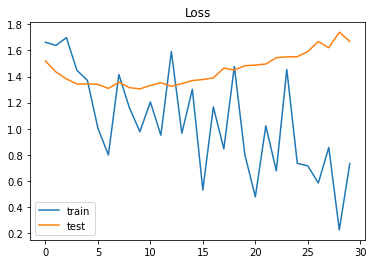

In [17]:
plt.plot(t_loss_his, label="train")
plt.plot(v_loss_his, label="test")
plt.title("Loss")
plt.legend()
plt.show()

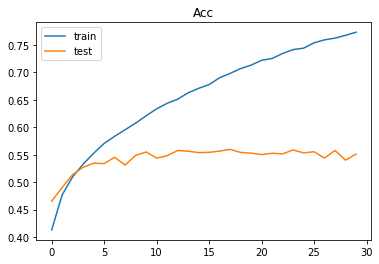

In [18]:
plt.plot(t_acc_his, label="train")
plt.plot(v_acc_his, label="test")
plt.title("Acc")
plt.legend()
plt.show()

In [19]:
t_loss, t_acc = evaluate(model, test_loader)
print("Test Loss : {:.4f}\t accuracy: {:.2f}%\n".format(t_loss, t_acc*100.))

  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 1.6867	 accuracy: 54.73%



### CNN

In [20]:
model = CNN().to(DEVICE)
opt = optim.AdamW(model.parameters())

print("Device :", DEVICE)
summary_(model,(3,32,32), device=DEVICE)

Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
         MaxPool2d-7             [-1, 32, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          18,496
              ReLU-9             [-1, 64, 8, 8]               0
        MaxPool2d-10             [-1, 64, 4, 4]               0
           Conv2d-11            [-1, 128, 4, 4]          73,856
             ReLU-12            [-1, 128, 4, 4]               0
        MaxPool2d-13            [-1, 128, 2, 2]               0
AdaptiveAvgPool2d-14     

In [21]:
t_loss_his, t_acc_his, v_loss_his, v_acc_his = train(EPOCHS = 30, model = model, train_loader = train_loader, test_loader = test_loader, opt = opt)

<<< EPOCH 1 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.974538	 Acc : 0.028
Training : [12800/50000 (26%)]	Loss: 1.694653	 Acc : 0.067
Training : [19200/50000 (38%)]	Loss: 2.016005	 Acc : 0.112
Training : [25600/50000 (51%)]	Loss: 1.418247	 Acc : 0.164
Training : [32000/50000 (64%)]	Loss: 1.617898	 Acc : 0.220
Training : [38400/50000 (77%)]	Loss: 1.459646	 Acc : 0.278
Training : [44800/50000 (90%)]	Loss: 1.364911	 Acc : 0.340
Training : [50000/50000 (100%)]	Loss: 1.231495	 Acc : 0.391


  0%|          | 0/157 [00:00<?, ?it/s]

[1] Test Loss : 1.3294	 accuracy: 50.69%

<<< EPOCH 2 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.327226	 Acc : 0.068
Training : [12800/50000 (26%)]	Loss: 1.122900	 Acc : 0.137
Training : [19200/50000 (38%)]	Loss: 1.170770	 Acc : 0.207
Training : [25600/50000 (51%)]	Loss: 1.332347	 Acc : 0.280
Training : [32000/50000 (64%)]	Loss: 1.348678	 Acc : 0.353
Training : [38400/50000 (77%)]	Loss: 1.038246	 Acc : 0.428
Training : [44800/50000 (90%)]	Loss: 1.255093	 Acc : 0.504
Training : [50000/50000 (100%)]	Loss: 1.156829	 Acc : 0.567


  0%|          | 0/157 [00:00<?, ?it/s]

[2] Test Loss : 1.1369	 accuracy: 58.89%

<<< EPOCH 3 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.011556	 Acc : 0.079
Training : [12800/50000 (26%)]	Loss: 0.799439	 Acc : 0.158
Training : [19200/50000 (38%)]	Loss: 0.959906	 Acc : 0.238
Training : [25600/50000 (51%)]	Loss: 1.238341	 Acc : 0.317
Training : [32000/50000 (64%)]	Loss: 0.944609	 Acc : 0.398
Training : [38400/50000 (77%)]	Loss: 0.980278	 Acc : 0.478
Training : [44800/50000 (90%)]	Loss: 1.083319	 Acc : 0.561
Training : [50000/50000 (100%)]	Loss: 0.896150	 Acc : 0.627


  0%|          | 0/157 [00:00<?, ?it/s]

[3] Test Loss : 0.9651	 accuracy: 65.85%

<<< EPOCH 4 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.279147	 Acc : 0.085
Training : [12800/50000 (26%)]	Loss: 0.979334	 Acc : 0.168
Training : [19200/50000 (38%)]	Loss: 0.985164	 Acc : 0.251
Training : [25600/50000 (51%)]	Loss: 0.995654	 Acc : 0.336
Training : [32000/50000 (64%)]	Loss: 0.933589	 Acc : 0.421
Training : [38400/50000 (77%)]	Loss: 1.061988	 Acc : 0.508
Training : [44800/50000 (90%)]	Loss: 0.901079	 Acc : 0.594
Training : [50000/50000 (100%)]	Loss: 0.921056	 Acc : 0.663


  0%|          | 0/157 [00:00<?, ?it/s]

[4] Test Loss : 0.8621	 accuracy: 69.90%

<<< EPOCH 5 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.840098	 Acc : 0.089
Training : [12800/50000 (26%)]	Loss: 0.847753	 Acc : 0.176
Training : [19200/50000 (38%)]	Loss: 0.864136	 Acc : 0.264
Training : [25600/50000 (51%)]	Loss: 0.962623	 Acc : 0.353
Training : [32000/50000 (64%)]	Loss: 0.793547	 Acc : 0.442
Training : [38400/50000 (77%)]	Loss: 0.820450	 Acc : 0.532
Training : [44800/50000 (90%)]	Loss: 0.932761	 Acc : 0.622
Training : [50000/50000 (100%)]	Loss: 0.986640	 Acc : 0.694


  0%|          | 0/157 [00:00<?, ?it/s]

[5] Test Loss : 0.8447	 accuracy: 70.96%

<<< EPOCH 6 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.816821	 Acc : 0.092
Training : [12800/50000 (26%)]	Loss: 0.799760	 Acc : 0.184
Training : [19200/50000 (38%)]	Loss: 0.999247	 Acc : 0.275
Training : [25600/50000 (51%)]	Loss: 0.803684	 Acc : 0.367
Training : [32000/50000 (64%)]	Loss: 0.774908	 Acc : 0.458
Training : [38400/50000 (77%)]	Loss: 0.788315	 Acc : 0.551
Training : [44800/50000 (90%)]	Loss: 0.779017	 Acc : 0.642
Training : [50000/50000 (100%)]	Loss: 0.736440	 Acc : 0.716


  0%|          | 0/157 [00:00<?, ?it/s]

[6] Test Loss : 0.8574	 accuracy: 70.37%

<<< EPOCH 7 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.731051	 Acc : 0.094
Training : [12800/50000 (26%)]	Loss: 1.014320	 Acc : 0.188
Training : [19200/50000 (38%)]	Loss: 0.730298	 Acc : 0.281
Training : [25600/50000 (51%)]	Loss: 1.048772	 Acc : 0.372
Training : [32000/50000 (64%)]	Loss: 0.882191	 Acc : 0.467
Training : [38400/50000 (77%)]	Loss: 0.740628	 Acc : 0.561
Training : [44800/50000 (90%)]	Loss: 0.591629	 Acc : 0.655
Training : [50000/50000 (100%)]	Loss: 0.550940	 Acc : 0.732


  0%|          | 0/157 [00:00<?, ?it/s]

[7] Test Loss : 0.7725	 accuracy: 73.77%

<<< EPOCH 8 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.764458	 Acc : 0.097
Training : [12800/50000 (26%)]	Loss: 0.676756	 Acc : 0.193
Training : [19200/50000 (38%)]	Loss: 0.777166	 Acc : 0.289
Training : [25600/50000 (51%)]	Loss: 1.105437	 Acc : 0.384
Training : [32000/50000 (64%)]	Loss: 0.581910	 Acc : 0.480
Training : [38400/50000 (77%)]	Loss: 0.786987	 Acc : 0.576
Training : [44800/50000 (90%)]	Loss: 0.635243	 Acc : 0.672
Training : [50000/50000 (100%)]	Loss: 0.975622	 Acc : 0.750


  0%|          | 0/157 [00:00<?, ?it/s]

[8] Test Loss : 0.7905	 accuracy: 73.02%

<<< EPOCH 9 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.554964	 Acc : 0.099
Training : [12800/50000 (26%)]	Loss: 0.973913	 Acc : 0.197
Training : [19200/50000 (38%)]	Loss: 0.831885	 Acc : 0.294
Training : [25600/50000 (51%)]	Loss: 0.693726	 Acc : 0.391
Training : [32000/50000 (64%)]	Loss: 0.586363	 Acc : 0.490
Training : [38400/50000 (77%)]	Loss: 0.832533	 Acc : 0.585
Training : [44800/50000 (90%)]	Loss: 0.701235	 Acc : 0.684
Training : [50000/50000 (100%)]	Loss: 0.530751	 Acc : 0.763


  0%|          | 0/157 [00:00<?, ?it/s]

[9] Test Loss : 0.7361	 accuracy: 74.53%

<<< EPOCH 10 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.659812	 Acc : 0.099
Training : [12800/50000 (26%)]	Loss: 0.749295	 Acc : 0.198
Training : [19200/50000 (38%)]	Loss: 0.780818	 Acc : 0.296
Training : [25600/50000 (51%)]	Loss: 0.626582	 Acc : 0.395
Training : [32000/50000 (64%)]	Loss: 0.816300	 Acc : 0.494
Training : [38400/50000 (77%)]	Loss: 0.606889	 Acc : 0.594
Training : [44800/50000 (90%)]	Loss: 0.811577	 Acc : 0.693
Training : [50000/50000 (100%)]	Loss: 0.950655	 Acc : 0.772


  0%|          | 0/157 [00:00<?, ?it/s]

[10] Test Loss : 0.7053	 accuracy: 76.12%

<<< EPOCH 11 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.669232	 Acc : 0.101
Training : [12800/50000 (26%)]	Loss: 0.568271	 Acc : 0.202
Training : [19200/50000 (38%)]	Loss: 0.617352	 Acc : 0.300
Training : [25600/50000 (51%)]	Loss: 0.621120	 Acc : 0.399
Training : [32000/50000 (64%)]	Loss: 0.594331	 Acc : 0.500
Training : [38400/50000 (77%)]	Loss: 0.732217	 Acc : 0.599
Training : [44800/50000 (90%)]	Loss: 0.510268	 Acc : 0.700
Training : [50000/50000 (100%)]	Loss: 0.522923	 Acc : 0.780


  0%|          | 0/157 [00:00<?, ?it/s]

[11] Test Loss : 0.6758	 accuracy: 76.86%

<<< EPOCH 12 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.767042	 Acc : 0.102
Training : [12800/50000 (26%)]	Loss: 0.747304	 Acc : 0.203
Training : [19200/50000 (38%)]	Loss: 0.715706	 Acc : 0.304
Training : [25600/50000 (51%)]	Loss: 0.750787	 Acc : 0.405
Training : [32000/50000 (64%)]	Loss: 0.442526	 Acc : 0.506
Training : [38400/50000 (77%)]	Loss: 0.635317	 Acc : 0.607
Training : [44800/50000 (90%)]	Loss: 0.628265	 Acc : 0.707
Training : [50000/50000 (100%)]	Loss: 1.298324	 Acc : 0.788


  0%|          | 0/157 [00:00<?, ?it/s]

[12] Test Loss : 0.6580	 accuracy: 77.75%

<<< EPOCH 13 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.704989	 Acc : 0.104
Training : [12800/50000 (26%)]	Loss: 0.715675	 Acc : 0.207
Training : [19200/50000 (38%)]	Loss: 0.690129	 Acc : 0.309
Training : [25600/50000 (51%)]	Loss: 0.771675	 Acc : 0.411
Training : [32000/50000 (64%)]	Loss: 0.669378	 Acc : 0.513
Training : [38400/50000 (77%)]	Loss: 0.359932	 Acc : 0.616
Training : [44800/50000 (90%)]	Loss: 0.591180	 Acc : 0.717
Training : [50000/50000 (100%)]	Loss: 0.598598	 Acc : 0.799


  0%|          | 0/157 [00:00<?, ?it/s]

[13] Test Loss : 0.6866	 accuracy: 77.27%

<<< EPOCH 14 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.561715	 Acc : 0.104
Training : [12800/50000 (26%)]	Loss: 0.413394	 Acc : 0.207
Training : [19200/50000 (38%)]	Loss: 0.807586	 Acc : 0.310
Training : [25600/50000 (51%)]	Loss: 0.708391	 Acc : 0.413
Training : [32000/50000 (64%)]	Loss: 0.468174	 Acc : 0.516
Training : [38400/50000 (77%)]	Loss: 0.611024	 Acc : 0.618
Training : [44800/50000 (90%)]	Loss: 0.671577	 Acc : 0.720
Training : [50000/50000 (100%)]	Loss: 0.463504	 Acc : 0.803


  0%|          | 0/157 [00:00<?, ?it/s]

[14] Test Loss : 0.6523	 accuracy: 77.94%

<<< EPOCH 15 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.410674	 Acc : 0.105
Training : [12800/50000 (26%)]	Loss: 0.430133	 Acc : 0.209
Training : [19200/50000 (38%)]	Loss: 0.539562	 Acc : 0.313
Training : [25600/50000 (51%)]	Loss: 0.519491	 Acc : 0.417
Training : [32000/50000 (64%)]	Loss: 0.532561	 Acc : 0.520
Training : [38400/50000 (77%)]	Loss: 0.611446	 Acc : 0.623
Training : [44800/50000 (90%)]	Loss: 0.441299	 Acc : 0.727
Training : [50000/50000 (100%)]	Loss: 0.357392	 Acc : 0.810


  0%|          | 0/157 [00:00<?, ?it/s]

[15] Test Loss : 0.6550	 accuracy: 78.06%

<<< EPOCH 16 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.356419	 Acc : 0.106
Training : [12800/50000 (26%)]	Loss: 0.600965	 Acc : 0.210
Training : [19200/50000 (38%)]	Loss: 0.595786	 Acc : 0.315
Training : [25600/50000 (51%)]	Loss: 0.565797	 Acc : 0.421
Training : [32000/50000 (64%)]	Loss: 0.534780	 Acc : 0.525
Training : [38400/50000 (77%)]	Loss: 1.062888	 Acc : 0.629
Training : [44800/50000 (90%)]	Loss: 0.559367	 Acc : 0.732
Training : [50000/50000 (100%)]	Loss: 0.336488	 Acc : 0.816


  0%|          | 0/157 [00:00<?, ?it/s]

[16] Test Loss : 0.6660	 accuracy: 78.20%

<<< EPOCH 17 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.630354	 Acc : 0.106
Training : [12800/50000 (26%)]	Loss: 0.449730	 Acc : 0.213
Training : [19200/50000 (38%)]	Loss: 0.547659	 Acc : 0.318
Training : [25600/50000 (51%)]	Loss: 0.613176	 Acc : 0.423
Training : [32000/50000 (64%)]	Loss: 0.488481	 Acc : 0.527
Training : [38400/50000 (77%)]	Loss: 0.337801	 Acc : 0.632
Training : [44800/50000 (90%)]	Loss: 0.425862	 Acc : 0.738
Training : [50000/50000 (100%)]	Loss: 0.104137	 Acc : 0.822


  0%|          | 0/157 [00:00<?, ?it/s]

[17] Test Loss : 0.6370	 accuracy: 78.88%

<<< EPOCH 18 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.357419	 Acc : 0.107
Training : [12800/50000 (26%)]	Loss: 0.739491	 Acc : 0.213
Training : [19200/50000 (38%)]	Loss: 0.498216	 Acc : 0.319
Training : [25600/50000 (51%)]	Loss: 0.490957	 Acc : 0.425
Training : [32000/50000 (64%)]	Loss: 0.449087	 Acc : 0.530
Training : [38400/50000 (77%)]	Loss: 0.921903	 Acc : 0.635
Training : [44800/50000 (90%)]	Loss: 0.336501	 Acc : 0.741
Training : [50000/50000 (100%)]	Loss: 0.657954	 Acc : 0.825


  0%|          | 0/157 [00:00<?, ?it/s]

[18] Test Loss : 0.6502	 accuracy: 78.32%

<<< EPOCH 19 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.457464	 Acc : 0.107
Training : [12800/50000 (26%)]	Loss: 0.549970	 Acc : 0.214
Training : [19200/50000 (38%)]	Loss: 0.369747	 Acc : 0.321
Training : [25600/50000 (51%)]	Loss: 0.301269	 Acc : 0.426
Training : [32000/50000 (64%)]	Loss: 0.868024	 Acc : 0.531
Training : [38400/50000 (77%)]	Loss: 0.650409	 Acc : 0.637
Training : [44800/50000 (90%)]	Loss: 0.632746	 Acc : 0.742
Training : [50000/50000 (100%)]	Loss: 0.406599	 Acc : 0.827


  0%|          | 0/157 [00:00<?, ?it/s]

[19] Test Loss : 0.6623	 accuracy: 78.61%

<<< EPOCH 20 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.490716	 Acc : 0.107
Training : [12800/50000 (26%)]	Loss: 0.491614	 Acc : 0.215
Training : [19200/50000 (38%)]	Loss: 0.435261	 Acc : 0.321
Training : [25600/50000 (51%)]	Loss: 0.385488	 Acc : 0.427
Training : [32000/50000 (64%)]	Loss: 0.319690	 Acc : 0.533
Training : [38400/50000 (77%)]	Loss: 0.737545	 Acc : 0.639
Training : [44800/50000 (90%)]	Loss: 0.779211	 Acc : 0.744
Training : [50000/50000 (100%)]	Loss: 0.984331	 Acc : 0.830


  0%|          | 0/157 [00:00<?, ?it/s]

[20] Test Loss : 0.6828	 accuracy: 78.02%

<<< EPOCH 21 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.508849	 Acc : 0.108
Training : [12800/50000 (26%)]	Loss: 0.423184	 Acc : 0.216
Training : [19200/50000 (38%)]	Loss: 0.511284	 Acc : 0.323
Training : [25600/50000 (51%)]	Loss: 0.508255	 Acc : 0.430
Training : [32000/50000 (64%)]	Loss: 0.446488	 Acc : 0.537
Training : [38400/50000 (77%)]	Loss: 0.416562	 Acc : 0.644
Training : [44800/50000 (90%)]	Loss: 0.548417	 Acc : 0.751
Training : [50000/50000 (100%)]	Loss: 0.228791	 Acc : 0.837


  0%|          | 0/157 [00:00<?, ?it/s]

[21] Test Loss : 0.6354	 accuracy: 79.08%

<<< EPOCH 22 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.361417	 Acc : 0.111
Training : [12800/50000 (26%)]	Loss: 0.534087	 Acc : 0.220
Training : [19200/50000 (38%)]	Loss: 0.541147	 Acc : 0.328
Training : [25600/50000 (51%)]	Loss: 0.577122	 Acc : 0.435
Training : [32000/50000 (64%)]	Loss: 0.580259	 Acc : 0.543
Training : [38400/50000 (77%)]	Loss: 0.527747	 Acc : 0.650
Training : [44800/50000 (90%)]	Loss: 0.404080	 Acc : 0.758
Training : [50000/50000 (100%)]	Loss: 0.227174	 Acc : 0.845


  0%|          | 0/157 [00:00<?, ?it/s]

[22] Test Loss : 0.6576	 accuracy: 78.50%

<<< EPOCH 23 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.365241	 Acc : 0.110
Training : [12800/50000 (26%)]	Loss: 0.343797	 Acc : 0.219
Training : [19200/50000 (38%)]	Loss: 0.361932	 Acc : 0.328
Training : [25600/50000 (51%)]	Loss: 0.627859	 Acc : 0.436
Training : [32000/50000 (64%)]	Loss: 0.397613	 Acc : 0.545
Training : [38400/50000 (77%)]	Loss: 0.272457	 Acc : 0.652
Training : [44800/50000 (90%)]	Loss: 0.695837	 Acc : 0.759
Training : [50000/50000 (100%)]	Loss: 0.682738	 Acc : 0.847


  0%|          | 0/157 [00:00<?, ?it/s]

[23] Test Loss : 0.6818	 accuracy: 78.79%

<<< EPOCH 24 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.357592	 Acc : 0.110
Training : [12800/50000 (26%)]	Loss: 0.419972	 Acc : 0.219
Training : [19200/50000 (38%)]	Loss: 0.633837	 Acc : 0.328
Training : [25600/50000 (51%)]	Loss: 0.554745	 Acc : 0.437
Training : [32000/50000 (64%)]	Loss: 0.564770	 Acc : 0.545
Training : [38400/50000 (77%)]	Loss: 0.452130	 Acc : 0.654
Training : [44800/50000 (90%)]	Loss: 0.341679	 Acc : 0.761
Training : [50000/50000 (100%)]	Loss: 1.197877	 Acc : 0.848


  0%|          | 0/157 [00:00<?, ?it/s]

[24] Test Loss : 0.6775	 accuracy: 78.69%

<<< EPOCH 25 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.472412	 Acc : 0.110
Training : [12800/50000 (26%)]	Loss: 0.458800	 Acc : 0.219
Training : [19200/50000 (38%)]	Loss: 0.416863	 Acc : 0.329
Training : [25600/50000 (51%)]	Loss: 0.496289	 Acc : 0.437
Training : [32000/50000 (64%)]	Loss: 0.483487	 Acc : 0.547
Training : [38400/50000 (77%)]	Loss: 0.599942	 Acc : 0.655
Training : [44800/50000 (90%)]	Loss: 0.398570	 Acc : 0.763
Training : [50000/50000 (100%)]	Loss: 0.210731	 Acc : 0.850


  0%|          | 0/157 [00:00<?, ?it/s]

[25] Test Loss : 0.6667	 accuracy: 79.00%

<<< EPOCH 26 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.508416	 Acc : 0.111
Training : [12800/50000 (26%)]	Loss: 0.366229	 Acc : 0.221
Training : [19200/50000 (38%)]	Loss: 0.263726	 Acc : 0.331
Training : [25600/50000 (51%)]	Loss: 0.365670	 Acc : 0.440
Training : [32000/50000 (64%)]	Loss: 0.445447	 Acc : 0.550
Training : [38400/50000 (77%)]	Loss: 0.565436	 Acc : 0.659
Training : [44800/50000 (90%)]	Loss: 0.376129	 Acc : 0.768
Training : [50000/50000 (100%)]	Loss: 0.323506	 Acc : 0.855


  0%|          | 0/157 [00:00<?, ?it/s]

[26] Test Loss : 0.6846	 accuracy: 78.48%

<<< EPOCH 27 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.352605	 Acc : 0.112
Training : [12800/50000 (26%)]	Loss: 0.272416	 Acc : 0.223
Training : [19200/50000 (38%)]	Loss: 0.331495	 Acc : 0.333
Training : [25600/50000 (51%)]	Loss: 0.226008	 Acc : 0.444
Training : [32000/50000 (64%)]	Loss: 0.420339	 Acc : 0.553
Training : [38400/50000 (77%)]	Loss: 0.619235	 Acc : 0.663
Training : [44800/50000 (90%)]	Loss: 0.497756	 Acc : 0.772
Training : [50000/50000 (100%)]	Loss: 0.662628	 Acc : 0.860


  0%|          | 0/157 [00:00<?, ?it/s]

[27] Test Loss : 0.6636	 accuracy: 78.64%

<<< EPOCH 28 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.399440	 Acc : 0.111
Training : [12800/50000 (26%)]	Loss: 0.435782	 Acc : 0.222
Training : [19200/50000 (38%)]	Loss: 0.247103	 Acc : 0.332
Training : [25600/50000 (51%)]	Loss: 0.376714	 Acc : 0.443
Training : [32000/50000 (64%)]	Loss: 0.368006	 Acc : 0.554
Training : [38400/50000 (77%)]	Loss: 0.382475	 Acc : 0.663
Training : [44800/50000 (90%)]	Loss: 0.281964	 Acc : 0.771
Training : [50000/50000 (100%)]	Loss: 0.324572	 Acc : 0.859


  0%|          | 0/157 [00:00<?, ?it/s]

[28] Test Loss : 0.6856	 accuracy: 78.19%

<<< EPOCH 29 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.502156	 Acc : 0.112
Training : [12800/50000 (26%)]	Loss: 0.282199	 Acc : 0.222
Training : [19200/50000 (38%)]	Loss: 0.439886	 Acc : 0.334
Training : [25600/50000 (51%)]	Loss: 0.218273	 Acc : 0.444
Training : [32000/50000 (64%)]	Loss: 0.360438	 Acc : 0.554
Training : [38400/50000 (77%)]	Loss: 0.469622	 Acc : 0.665
Training : [44800/50000 (90%)]	Loss: 0.365984	 Acc : 0.775
Training : [50000/50000 (100%)]	Loss: 0.191042	 Acc : 0.864


  0%|          | 0/157 [00:00<?, ?it/s]

[29] Test Loss : 0.6703	 accuracy: 79.60%

<<< EPOCH 30 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.307197	 Acc : 0.113
Training : [12800/50000 (26%)]	Loss: 0.357358	 Acc : 0.224
Training : [19200/50000 (38%)]	Loss: 0.408975	 Acc : 0.335
Training : [25600/50000 (51%)]	Loss: 0.651166	 Acc : 0.446
Training : [32000/50000 (64%)]	Loss: 0.413013	 Acc : 0.556
Training : [38400/50000 (77%)]	Loss: 0.449919	 Acc : 0.667
Training : [44800/50000 (90%)]	Loss: 0.246105	 Acc : 0.778
Training : [50000/50000 (100%)]	Loss: 0.266454	 Acc : 0.866


  0%|          | 0/157 [00:00<?, ?it/s]

[30] Test Loss : 0.6851	 accuracy: 79.03%



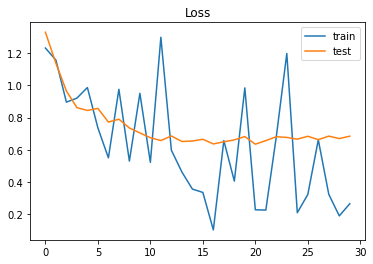

In [22]:
plt.plot(t_loss_his, label="train")
plt.plot(v_loss_his, label="test")
plt.title("Loss")
plt.legend()
plt.show()

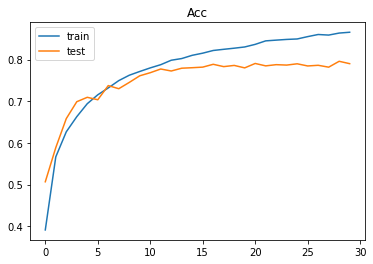

In [23]:
plt.plot(t_acc_his, label="train")
plt.plot(v_acc_his, label="test")
plt.title("Acc")
plt.legend()
plt.show()

In [24]:
t_loss, t_acc = evaluate(model, test_loader)
print("Test Loss : {:.4f}\t accuracy: {:.2f}%\n".format(t_loss, t_acc*100.))

  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 0.6770	 accuracy: 79.39%



### CNN(with Attention)

In [37]:
model = CNN_with_Att().to(DEVICE)
opt = optim.AdamW(model.parameters())

print("Device :", DEVICE)
summary_(model,(3,32,32), device=DEVICE)

Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
           Sigmoid-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
       BatchNorm2d-8           [-1, 32, 16, 16]              64
         LeakyReLU-9           [-1, 32, 16, 16]               0
        MaxPool2d-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 8, 8]          18,496
      BatchNorm2d-12             [-1, 64, 8, 8]             128
        LeakyReLU-13             [-1, 64, 8, 8]               0
        MaxPool2d-14     

In [38]:
t_loss_his, t_acc_his, v_loss_his, v_acc_his = train(EPOCHS = 30, model = model, train_loader = train_loader, test_loader = test_loader, opt = opt)

<<< EPOCH 1 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.655612	 Acc : 0.042
Training : [12800/50000 (26%)]	Loss: 1.541252	 Acc : 0.101
Training : [19200/50000 (38%)]	Loss: 1.342483	 Acc : 0.166
Training : [25600/50000 (51%)]	Loss: 1.386426	 Acc : 0.236
Training : [32000/50000 (64%)]	Loss: 1.140478	 Acc : 0.311
Training : [38400/50000 (77%)]	Loss: 0.840781	 Acc : 0.390
Training : [44800/50000 (90%)]	Loss: 0.952265	 Acc : 0.470
Training : [50000/50000 (100%)]	Loss: 1.449838	 Acc : 0.536


  0%|          | 0/157 [00:00<?, ?it/s]

[1] Test Loss : 1.0514	 accuracy: 62.95%

<<< EPOCH 2 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 1.177520	 Acc : 0.084
Training : [12800/50000 (26%)]	Loss: 0.911123	 Acc : 0.168
Training : [19200/50000 (38%)]	Loss: 0.971002	 Acc : 0.254
Training : [25600/50000 (51%)]	Loss: 0.737639	 Acc : 0.341
Training : [32000/50000 (64%)]	Loss: 0.920951	 Acc : 0.430
Training : [38400/50000 (77%)]	Loss: 0.863498	 Acc : 0.517
Training : [44800/50000 (90%)]	Loss: 0.945145	 Acc : 0.606
Training : [50000/50000 (100%)]	Loss: 0.939946	 Acc : 0.677


  0%|          | 0/157 [00:00<?, ?it/s]

[2] Test Loss : 0.8453	 accuracy: 70.20%

<<< EPOCH 3 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.749896	 Acc : 0.091
Training : [12800/50000 (26%)]	Loss: 0.786077	 Acc : 0.183
Training : [19200/50000 (38%)]	Loss: 0.980971	 Acc : 0.275
Training : [25600/50000 (51%)]	Loss: 0.810728	 Acc : 0.368
Training : [32000/50000 (64%)]	Loss: 0.795275	 Acc : 0.461
Training : [38400/50000 (77%)]	Loss: 0.746244	 Acc : 0.555
Training : [44800/50000 (90%)]	Loss: 0.942853	 Acc : 0.648
Training : [50000/50000 (100%)]	Loss: 0.805649	 Acc : 0.722


  0%|          | 0/157 [00:00<?, ?it/s]

[3] Test Loss : 0.7974	 accuracy: 72.66%

<<< EPOCH 4 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.602585	 Acc : 0.096
Training : [12800/50000 (26%)]	Loss: 0.748639	 Acc : 0.192
Training : [19200/50000 (38%)]	Loss: 0.559503	 Acc : 0.288
Training : [25600/50000 (51%)]	Loss: 0.781286	 Acc : 0.384
Training : [32000/50000 (64%)]	Loss: 0.780352	 Acc : 0.480
Training : [38400/50000 (77%)]	Loss: 0.723869	 Acc : 0.576
Training : [44800/50000 (90%)]	Loss: 0.655499	 Acc : 0.672
Training : [50000/50000 (100%)]	Loss: 0.804959	 Acc : 0.749


  0%|          | 0/157 [00:00<?, ?it/s]

[4] Test Loss : 0.6935	 accuracy: 76.21%

<<< EPOCH 5 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.827693	 Acc : 0.098
Training : [12800/50000 (26%)]	Loss: 0.636173	 Acc : 0.198
Training : [19200/50000 (38%)]	Loss: 0.693013	 Acc : 0.296
Training : [25600/50000 (51%)]	Loss: 0.793376	 Acc : 0.395
Training : [32000/50000 (64%)]	Loss: 0.743813	 Acc : 0.492
Training : [38400/50000 (77%)]	Loss: 0.449805	 Acc : 0.591
Training : [44800/50000 (90%)]	Loss: 0.593800	 Acc : 0.690
Training : [50000/50000 (100%)]	Loss: 0.476504	 Acc : 0.768


  0%|          | 0/157 [00:00<?, ?it/s]

[5] Test Loss : 0.6865	 accuracy: 76.62%

<<< EPOCH 6 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.759171	 Acc : 0.101
Training : [12800/50000 (26%)]	Loss: 0.725758	 Acc : 0.202
Training : [19200/50000 (38%)]	Loss: 0.669030	 Acc : 0.301
Training : [25600/50000 (51%)]	Loss: 0.773780	 Acc : 0.402
Training : [32000/50000 (64%)]	Loss: 0.740979	 Acc : 0.501
Training : [38400/50000 (77%)]	Loss: 0.805250	 Acc : 0.600
Training : [44800/50000 (90%)]	Loss: 0.689101	 Acc : 0.702
Training : [50000/50000 (100%)]	Loss: 0.558874	 Acc : 0.782


  0%|          | 0/157 [00:00<?, ?it/s]

[6] Test Loss : 0.6956	 accuracy: 75.96%

<<< EPOCH 7 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.674491	 Acc : 0.104
Training : [12800/50000 (26%)]	Loss: 0.527811	 Acc : 0.206
Training : [19200/50000 (38%)]	Loss: 0.455331	 Acc : 0.309
Training : [25600/50000 (51%)]	Loss: 0.530836	 Acc : 0.410
Training : [32000/50000 (64%)]	Loss: 0.533262	 Acc : 0.510
Training : [38400/50000 (77%)]	Loss: 0.579333	 Acc : 0.612
Training : [44800/50000 (90%)]	Loss: 0.693477	 Acc : 0.712
Training : [50000/50000 (100%)]	Loss: 0.664315	 Acc : 0.793


  0%|          | 0/157 [00:00<?, ?it/s]

[7] Test Loss : 0.6869	 accuracy: 76.99%

<<< EPOCH 8 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.387880	 Acc : 0.104
Training : [12800/50000 (26%)]	Loss: 0.504029	 Acc : 0.207
Training : [19200/50000 (38%)]	Loss: 0.410035	 Acc : 0.309
Training : [25600/50000 (51%)]	Loss: 0.619642	 Acc : 0.412
Training : [32000/50000 (64%)]	Loss: 0.568738	 Acc : 0.515
Training : [38400/50000 (77%)]	Loss: 0.695371	 Acc : 0.618
Training : [44800/50000 (90%)]	Loss: 0.524831	 Acc : 0.721
Training : [50000/50000 (100%)]	Loss: 0.734678	 Acc : 0.803


  0%|          | 0/157 [00:00<?, ?it/s]

[8] Test Loss : 0.6204	 accuracy: 78.97%

<<< EPOCH 9 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.700697	 Acc : 0.106
Training : [12800/50000 (26%)]	Loss: 0.444382	 Acc : 0.211
Training : [19200/50000 (38%)]	Loss: 0.577539	 Acc : 0.315
Training : [25600/50000 (51%)]	Loss: 0.435509	 Acc : 0.419
Training : [32000/50000 (64%)]	Loss: 0.678256	 Acc : 0.523
Training : [38400/50000 (77%)]	Loss: 0.503910	 Acc : 0.627
Training : [44800/50000 (90%)]	Loss: 0.496134	 Acc : 0.732
Training : [50000/50000 (100%)]	Loss: 0.707747	 Acc : 0.815


  0%|          | 0/157 [00:00<?, ?it/s]

[9] Test Loss : 0.6178	 accuracy: 79.37%

<<< EPOCH 10 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.380509	 Acc : 0.108
Training : [12800/50000 (26%)]	Loss: 0.490429	 Acc : 0.213
Training : [19200/50000 (38%)]	Loss: 0.563253	 Acc : 0.319
Training : [25600/50000 (51%)]	Loss: 0.437180	 Acc : 0.423
Training : [32000/50000 (64%)]	Loss: 0.483829	 Acc : 0.528
Training : [38400/50000 (77%)]	Loss: 0.572579	 Acc : 0.632
Training : [44800/50000 (90%)]	Loss: 0.567924	 Acc : 0.737
Training : [50000/50000 (100%)]	Loss: 0.455215	 Acc : 0.821


  0%|          | 0/157 [00:00<?, ?it/s]

[10] Test Loss : 0.6267	 accuracy: 78.87%

<<< EPOCH 11 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.631881	 Acc : 0.109
Training : [12800/50000 (26%)]	Loss: 0.452033	 Acc : 0.214
Training : [19200/50000 (38%)]	Loss: 0.362447	 Acc : 0.320
Training : [25600/50000 (51%)]	Loss: 0.653488	 Acc : 0.426
Training : [32000/50000 (64%)]	Loss: 0.611483	 Acc : 0.531
Training : [38400/50000 (77%)]	Loss: 0.392775	 Acc : 0.637
Training : [44800/50000 (90%)]	Loss: 0.460704	 Acc : 0.743
Training : [50000/50000 (100%)]	Loss: 0.459905	 Acc : 0.828


  0%|          | 0/157 [00:00<?, ?it/s]

[11] Test Loss : 0.5875	 accuracy: 80.11%

<<< EPOCH 12 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.485969	 Acc : 0.108
Training : [12800/50000 (26%)]	Loss: 0.733154	 Acc : 0.214
Training : [19200/50000 (38%)]	Loss: 0.557619	 Acc : 0.320
Training : [25600/50000 (51%)]	Loss: 0.706470	 Acc : 0.428
Training : [32000/50000 (64%)]	Loss: 0.537695	 Acc : 0.536
Training : [38400/50000 (77%)]	Loss: 0.418159	 Acc : 0.643
Training : [44800/50000 (90%)]	Loss: 0.684121	 Acc : 0.749
Training : [50000/50000 (100%)]	Loss: 0.489069	 Acc : 0.835


  0%|          | 0/157 [00:00<?, ?it/s]

[12] Test Loss : 0.6777	 accuracy: 77.67%

<<< EPOCH 13 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.385767	 Acc : 0.110
Training : [12800/50000 (26%)]	Loss: 0.459242	 Acc : 0.219
Training : [19200/50000 (38%)]	Loss: 0.660190	 Acc : 0.325
Training : [25600/50000 (51%)]	Loss: 0.470575	 Acc : 0.433
Training : [32000/50000 (64%)]	Loss: 0.659479	 Acc : 0.540
Training : [38400/50000 (77%)]	Loss: 0.429660	 Acc : 0.646
Training : [44800/50000 (90%)]	Loss: 0.465117	 Acc : 0.754
Training : [50000/50000 (100%)]	Loss: 0.554884	 Acc : 0.840


  0%|          | 0/157 [00:00<?, ?it/s]

[13] Test Loss : 0.6354	 accuracy: 79.11%

<<< EPOCH 14 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.471229	 Acc : 0.110
Training : [12800/50000 (26%)]	Loss: 0.414629	 Acc : 0.218
Training : [19200/50000 (38%)]	Loss: 0.295815	 Acc : 0.327
Training : [25600/50000 (51%)]	Loss: 0.299808	 Acc : 0.435
Training : [32000/50000 (64%)]	Loss: 0.438628	 Acc : 0.543
Training : [38400/50000 (77%)]	Loss: 0.271571	 Acc : 0.651
Training : [44800/50000 (90%)]	Loss: 0.459103	 Acc : 0.760
Training : [50000/50000 (100%)]	Loss: 0.828952	 Acc : 0.845


  0%|          | 0/157 [00:00<?, ?it/s]

[14] Test Loss : 0.6246	 accuracy: 79.51%

<<< EPOCH 15 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.553557	 Acc : 0.110
Training : [12800/50000 (26%)]	Loss: 0.515573	 Acc : 0.220
Training : [19200/50000 (38%)]	Loss: 0.461482	 Acc : 0.329
Training : [25600/50000 (51%)]	Loss: 0.440572	 Acc : 0.439
Training : [32000/50000 (64%)]	Loss: 0.619964	 Acc : 0.548
Training : [38400/50000 (77%)]	Loss: 0.538217	 Acc : 0.657
Training : [44800/50000 (90%)]	Loss: 0.408659	 Acc : 0.766
Training : [50000/50000 (100%)]	Loss: 0.876823	 Acc : 0.853


  0%|          | 0/157 [00:00<?, ?it/s]

[15] Test Loss : 0.6678	 accuracy: 78.64%

<<< EPOCH 16 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.345899	 Acc : 0.111
Training : [12800/50000 (26%)]	Loss: 0.587447	 Acc : 0.221
Training : [19200/50000 (38%)]	Loss: 0.412558	 Acc : 0.330
Training : [25600/50000 (51%)]	Loss: 0.548441	 Acc : 0.441
Training : [32000/50000 (64%)]	Loss: 0.335761	 Acc : 0.550
Training : [38400/50000 (77%)]	Loss: 0.530587	 Acc : 0.660
Training : [44800/50000 (90%)]	Loss: 0.455578	 Acc : 0.770
Training : [50000/50000 (100%)]	Loss: 0.601179	 Acc : 0.857


  0%|          | 0/157 [00:00<?, ?it/s]

[16] Test Loss : 0.6405	 accuracy: 79.29%

<<< EPOCH 17 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.415888	 Acc : 0.113
Training : [12800/50000 (26%)]	Loss: 0.390836	 Acc : 0.224
Training : [19200/50000 (38%)]	Loss: 0.485867	 Acc : 0.335
Training : [25600/50000 (51%)]	Loss: 0.333746	 Acc : 0.444
Training : [32000/50000 (64%)]	Loss: 0.378851	 Acc : 0.556
Training : [38400/50000 (77%)]	Loss: 0.412172	 Acc : 0.665
Training : [44800/50000 (90%)]	Loss: 0.655403	 Acc : 0.775
Training : [50000/50000 (100%)]	Loss: 0.348716	 Acc : 0.864


  0%|          | 0/157 [00:00<?, ?it/s]

[17] Test Loss : 0.6541	 accuracy: 79.54%

<<< EPOCH 18 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.268034	 Acc : 0.113
Training : [12800/50000 (26%)]	Loss: 0.678492	 Acc : 0.224
Training : [19200/50000 (38%)]	Loss: 0.454829	 Acc : 0.335
Training : [25600/50000 (51%)]	Loss: 0.304602	 Acc : 0.445
Training : [32000/50000 (64%)]	Loss: 0.238899	 Acc : 0.557
Training : [38400/50000 (77%)]	Loss: 0.275829	 Acc : 0.668
Training : [44800/50000 (90%)]	Loss: 0.446580	 Acc : 0.778
Training : [50000/50000 (100%)]	Loss: 0.727957	 Acc : 0.866


  0%|          | 0/157 [00:00<?, ?it/s]

[18] Test Loss : 0.5944	 accuracy: 80.67%

<<< EPOCH 19 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.333294	 Acc : 0.113
Training : [12800/50000 (26%)]	Loss: 0.372042	 Acc : 0.226
Training : [19200/50000 (38%)]	Loss: 0.291660	 Acc : 0.338
Training : [25600/50000 (51%)]	Loss: 0.236370	 Acc : 0.449
Training : [32000/50000 (64%)]	Loss: 0.301355	 Acc : 0.562
Training : [38400/50000 (77%)]	Loss: 0.556857	 Acc : 0.674
Training : [44800/50000 (90%)]	Loss: 0.455321	 Acc : 0.785
Training : [50000/50000 (100%)]	Loss: 0.769258	 Acc : 0.873


  0%|          | 0/157 [00:00<?, ?it/s]

[19] Test Loss : 0.6069	 accuracy: 80.12%

<<< EPOCH 20 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.380932	 Acc : 0.115
Training : [12800/50000 (26%)]	Loss: 0.224942	 Acc : 0.228
Training : [19200/50000 (38%)]	Loss: 0.301632	 Acc : 0.340
Training : [25600/50000 (51%)]	Loss: 0.405919	 Acc : 0.452
Training : [32000/50000 (64%)]	Loss: 0.365124	 Acc : 0.564
Training : [38400/50000 (77%)]	Loss: 0.322012	 Acc : 0.676
Training : [44800/50000 (90%)]	Loss: 0.352702	 Acc : 0.788
Training : [50000/50000 (100%)]	Loss: 0.375061	 Acc : 0.878


  0%|          | 0/157 [00:00<?, ?it/s]

[20] Test Loss : 0.6261	 accuracy: 80.46%

<<< EPOCH 21 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.295638	 Acc : 0.113
Training : [12800/50000 (26%)]	Loss: 0.275206	 Acc : 0.226
Training : [19200/50000 (38%)]	Loss: 0.287383	 Acc : 0.339
Training : [25600/50000 (51%)]	Loss: 0.212227	 Acc : 0.452
Training : [32000/50000 (64%)]	Loss: 0.269806	 Acc : 0.564
Training : [38400/50000 (77%)]	Loss: 0.229354	 Acc : 0.676
Training : [44800/50000 (90%)]	Loss: 0.319961	 Acc : 0.788
Training : [50000/50000 (100%)]	Loss: 0.534466	 Acc : 0.877


  0%|          | 0/157 [00:00<?, ?it/s]

[21] Test Loss : 0.5906	 accuracy: 81.31%

<<< EPOCH 22 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.377880	 Acc : 0.116
Training : [12800/50000 (26%)]	Loss: 0.173284	 Acc : 0.230
Training : [19200/50000 (38%)]	Loss: 0.373118	 Acc : 0.343
Training : [25600/50000 (51%)]	Loss: 0.484517	 Acc : 0.456
Training : [32000/50000 (64%)]	Loss: 0.271709	 Acc : 0.569
Training : [38400/50000 (77%)]	Loss: 0.354528	 Acc : 0.681
Training : [44800/50000 (90%)]	Loss: 0.477940	 Acc : 0.794
Training : [50000/50000 (100%)]	Loss: 0.561414	 Acc : 0.884


  0%|          | 0/157 [00:00<?, ?it/s]

[22] Test Loss : 0.6269	 accuracy: 80.53%

<<< EPOCH 23 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.338273	 Acc : 0.115
Training : [12800/50000 (26%)]	Loss: 0.329400	 Acc : 0.229
Training : [19200/50000 (38%)]	Loss: 0.211631	 Acc : 0.342
Training : [25600/50000 (51%)]	Loss: 0.293475	 Acc : 0.455
Training : [32000/50000 (64%)]	Loss: 0.438256	 Acc : 0.569
Training : [38400/50000 (77%)]	Loss: 0.307095	 Acc : 0.682
Training : [44800/50000 (90%)]	Loss: 0.408588	 Acc : 0.795
Training : [50000/50000 (100%)]	Loss: 0.464572	 Acc : 0.886


  0%|          | 0/157 [00:00<?, ?it/s]

[23] Test Loss : 0.6526	 accuracy: 79.89%

<<< EPOCH 24 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.353568	 Acc : 0.116
Training : [12800/50000 (26%)]	Loss: 0.452225	 Acc : 0.230
Training : [19200/50000 (38%)]	Loss: 0.347948	 Acc : 0.343
Training : [25600/50000 (51%)]	Loss: 0.293930	 Acc : 0.458
Training : [32000/50000 (64%)]	Loss: 0.273770	 Acc : 0.572
Training : [38400/50000 (77%)]	Loss: 0.439813	 Acc : 0.685
Training : [44800/50000 (90%)]	Loss: 0.285134	 Acc : 0.799
Training : [50000/50000 (100%)]	Loss: 0.691711	 Acc : 0.890


  0%|          | 0/157 [00:00<?, ?it/s]

[24] Test Loss : 0.6327	 accuracy: 80.36%

<<< EPOCH 25 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.217469	 Acc : 0.116
Training : [12800/50000 (26%)]	Loss: 0.370889	 Acc : 0.231
Training : [19200/50000 (38%)]	Loss: 0.266670	 Acc : 0.346
Training : [25600/50000 (51%)]	Loss: 0.307627	 Acc : 0.460
Training : [32000/50000 (64%)]	Loss: 0.317828	 Acc : 0.574
Training : [38400/50000 (77%)]	Loss: 0.226134	 Acc : 0.689
Training : [44800/50000 (90%)]	Loss: 0.262811	 Acc : 0.803
Training : [50000/50000 (100%)]	Loss: 0.165702	 Acc : 0.893


  0%|          | 0/157 [00:00<?, ?it/s]

[25] Test Loss : 0.6252	 accuracy: 80.98%

<<< EPOCH 26 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.476123	 Acc : 0.117
Training : [12800/50000 (26%)]	Loss: 0.394007	 Acc : 0.232
Training : [19200/50000 (38%)]	Loss: 0.273921	 Acc : 0.348
Training : [25600/50000 (51%)]	Loss: 0.228362	 Acc : 0.462
Training : [32000/50000 (64%)]	Loss: 0.311101	 Acc : 0.576
Training : [38400/50000 (77%)]	Loss: 0.456556	 Acc : 0.689
Training : [44800/50000 (90%)]	Loss: 0.213147	 Acc : 0.804
Training : [50000/50000 (100%)]	Loss: 0.624585	 Acc : 0.895


  0%|          | 0/157 [00:00<?, ?it/s]

[26] Test Loss : 0.6685	 accuracy: 80.42%

<<< EPOCH 27 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.239464	 Acc : 0.117
Training : [12800/50000 (26%)]	Loss: 0.167726	 Acc : 0.232
Training : [19200/50000 (38%)]	Loss: 0.249083	 Acc : 0.347
Training : [25600/50000 (51%)]	Loss: 0.309751	 Acc : 0.462
Training : [32000/50000 (64%)]	Loss: 0.322278	 Acc : 0.576
Training : [38400/50000 (77%)]	Loss: 0.311049	 Acc : 0.691
Training : [44800/50000 (90%)]	Loss: 0.215933	 Acc : 0.805
Training : [50000/50000 (100%)]	Loss: 0.436992	 Acc : 0.897


  0%|          | 0/157 [00:00<?, ?it/s]

[27] Test Loss : 0.6904	 accuracy: 80.28%

<<< EPOCH 28 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.187718	 Acc : 0.116
Training : [12800/50000 (26%)]	Loss: 0.314242	 Acc : 0.231
Training : [19200/50000 (38%)]	Loss: 0.264164	 Acc : 0.346
Training : [25600/50000 (51%)]	Loss: 0.354552	 Acc : 0.462
Training : [32000/50000 (64%)]	Loss: 0.318419	 Acc : 0.576
Training : [38400/50000 (77%)]	Loss: 0.259237	 Acc : 0.692
Training : [44800/50000 (90%)]	Loss: 0.247291	 Acc : 0.807
Training : [50000/50000 (100%)]	Loss: 0.270997	 Acc : 0.898


  0%|          | 0/157 [00:00<?, ?it/s]

[28] Test Loss : 0.6507	 accuracy: 80.84%

<<< EPOCH 29 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.429297	 Acc : 0.117
Training : [12800/50000 (26%)]	Loss: 0.218348	 Acc : 0.234
Training : [19200/50000 (38%)]	Loss: 0.282663	 Acc : 0.349
Training : [25600/50000 (51%)]	Loss: 0.353535	 Acc : 0.464
Training : [32000/50000 (64%)]	Loss: 0.238133	 Acc : 0.580
Training : [38400/50000 (77%)]	Loss: 0.508924	 Acc : 0.695
Training : [44800/50000 (90%)]	Loss: 0.137006	 Acc : 0.810
Training : [50000/50000 (100%)]	Loss: 0.995361	 Acc : 0.903


  0%|          | 0/157 [00:00<?, ?it/s]

[29] Test Loss : 0.6905	 accuracy: 80.27%

<<< EPOCH 30 >>>


  0%|          | 0/782 [00:00<?, ?it/s]

Training : [6400/50000 (13%)]	Loss: 0.230031	 Acc : 0.117
Training : [12800/50000 (26%)]	Loss: 0.296833	 Acc : 0.233
Training : [19200/50000 (38%)]	Loss: 0.738526	 Acc : 0.349
Training : [25600/50000 (51%)]	Loss: 0.291884	 Acc : 0.465
Training : [32000/50000 (64%)]	Loss: 0.281966	 Acc : 0.579
Training : [38400/50000 (77%)]	Loss: 0.229101	 Acc : 0.695
Training : [44800/50000 (90%)]	Loss: 0.230344	 Acc : 0.810
Training : [50000/50000 (100%)]	Loss: 0.423190	 Acc : 0.903


  0%|          | 0/157 [00:00<?, ?it/s]

[30] Test Loss : 0.6940	 accuracy: 80.06%



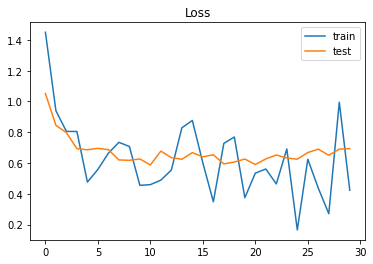

In [39]:
plt.plot(t_loss_his, label="train")
plt.plot(v_loss_his, label="test")
plt.title("Loss")
plt.legend()
plt.show()

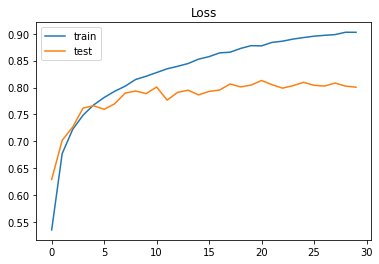

In [40]:
plt.plot(t_acc_his, label="train")
plt.plot(v_acc_his, label="test")
plt.title("Loss")
plt.legend()
plt.show()

In [41]:
t_loss, t_acc = evaluate(model, test_loader)
print("Test Loss : {:.4f}\t accuracy: {:.2f}%\n".format(t_loss, t_acc*100.))

  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 0.7055	 accuracy: 80.03%



## 분류 성능 직접 확인하기

In [ ]:
model.eval()
softmax = nn.Softmax(dim=1)

with torch.no_grad():
    _, (imgs, labels) = list(enumerate(test_loader))[13]
    for img, label in zip(imgs, labels):
        output = model(img.view(1,3,32,32).cuda())
        output = softmax(output)
        o_val, o_idx = torch.max(output, dim=1)

        print("실제값 :", label_names[label])
        print("예측값 :", label_names[o_idx])
        print("img's shape : {}".format(img.shape))
        plt.imshow(np.transpose(img, (1,2,0)))
        plt.title("Image")
        plt.show()
        print()